In [7]:
import warnings
warnings.filterwarnings('ignore')
from deepchecks.tabular.suites import full_suite
from skopt.plots import plot_objective, plot_evaluations, plot_convergence, plot_regret
from configs import music,santander_customer_satisfaction,Wids2021,ionosphere,fetal_health,santander,California,playground,Wine,Medicalpremium,Avocado
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score
import pickle
from skopt import dump, load
from matplotlib import pyplot as plt
import numpy as np
import glob
import pandas as pd
suite = full_suite()
def is_float(element) -> bool:
    try:
        float(element)
        return True
    except ValueError:
        return False
import seaborn as sns
sns.set()

In [29]:
def get_results(config_names,q=1):
    reg = []
    cla = []
    for config_name in config_names:
        with open(config_name, 'rb') as inp:
            config2 = pickle.load(inp)
            h = config2['history'][-1]            
            if "mean_squared_error" in h:
                mean_squared_error, r2, _ , mean_squared_error_alpha_0,_,r2_alpha0,run_time,size,fet =  [round(float(row),8) for row in h.replace(","," ").split(" ") if is_float(row)]
                reg.append([config_name.split(".pkl")[0].split("/")[1],mean_squared_error, r2 , mean_squared_error_alpha_0,r2_alpha0,run_time,size,fet])
            else:
                auc, auc_alpha0,run_time,size,fet =  [round(float(row),4) for row in h.replace(","," ").split(" ") if is_float(row)]
                y_pred_without_random = np.concatenate([config2['history'][row]['y_pred_without_random'] for row in range(5)],0)
                y_true =  np.concatenate([config2['history'][row]['y_val'] for row in range(5)],0)
                y_pred = np.concatenate([config2['history'][row]['y_pred'] for row in range(5)],0)
                acc1 = accuracy_score(y_true.astype(int),y_pred.argmax(1).astype(int))
                acc2 = accuracy_score(y_true.astype(int),y_pred_without_random.argmax(1).astype(int))
                cla.append([config_name.split(".pkl")[0].split("/")[1],auc,auc_alpha0,acc1,acc2,run_time,size,fet])
    df_cla = pd.DataFrame(cla,columns=['dataset',f'best_auc_{q}',f'baseline_auc_{q}',f'best_acc_{q}',f'baseline_acc_{q}',f'run_time_{q}',"total_size",'features'])
    df_reg = pd.DataFrame(reg,columns=['dataset',f'best_mse_{q}',f'best_r2_{q}',f'baseline_mse_{q}',f'baseline_r2_{q}',f'run_time_{q}',"total_size",'features'])
    return df_cla,df_reg

In [30]:
df_cla1,df_reg1 = get_results(glob.glob('outputs/*.pkl'),1)
df_cla3,df_reg3 = get_results(glob.glob('outputs3/*.pkl'),3)

In [31]:
df_reg = pd.merge(df_reg3[['dataset','best_mse_3','best_r2_3']],df_reg1,on='dataset')
df_reg

,dataset,best_mse_3,best_r2_3,best_mse_1,best_r2_1,baseline_mse_1,baseline_r2_1,run_time_1,total_size,features
0,santander,57.184594,0.156429,57.486705,0.151972,58.040977,0.143795,1406.927880,4459.0,998.0
1,California,0.003962,0.702437,0.004030,0.697351,0.004050,0.695868,1013.466887,20640.0,14.0
2,playground,0.544478,-0.020038,0.529683,0.007679,0.719841,-0.348569,688.369511,1000.0,15.0
3,Wine,0.412306,0.364495,0.424798,0.345241,0.479220,0.261357,671.528247,1143.0,13.0
4,Medical premium,0.081111,0.792025,0.086531,0.778126,0.085076,0.781858,692.984474,986.0,11.0
5,Avocado,0.074305,0.541720,0.076187,0.530114,0.076251,0.529720,1034.086154,18249.0,9.0


In [32]:
df_reg.to_csv("df_reg.csv",index=False)

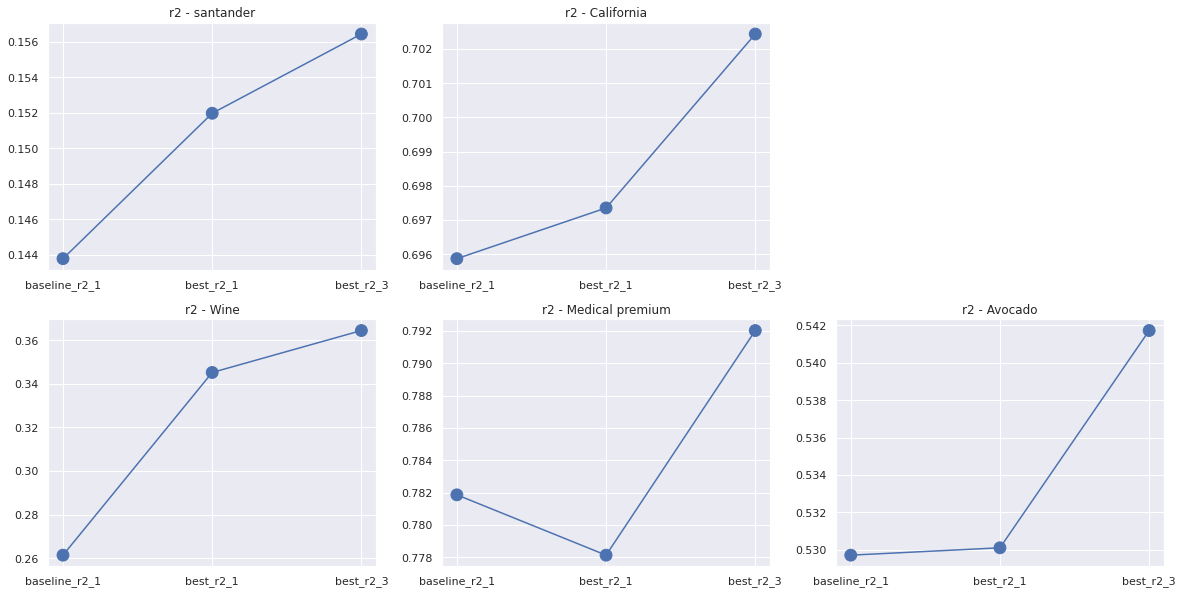

In [33]:
plt.figure(figsize=[20,10])
for row in range(6):
    d = df_reg.loc[row]['dataset']
    if d=="playground":
        continue
    plt.subplot(2,3,row+1)
    plt.scatter(['baseline_r2_1','best_r2_1','best_r2_3'],df_reg[['baseline_r2_1','best_r2_1','best_r2_3']].loc[row],s=[140,140,140])
    plt.plot(['baseline_r2_1','best_r2_1','best_r2_3'],df_reg[['baseline_r2_1','best_r2_1','best_r2_3']].loc[row])

    plt.title(f"r2 - {d}")

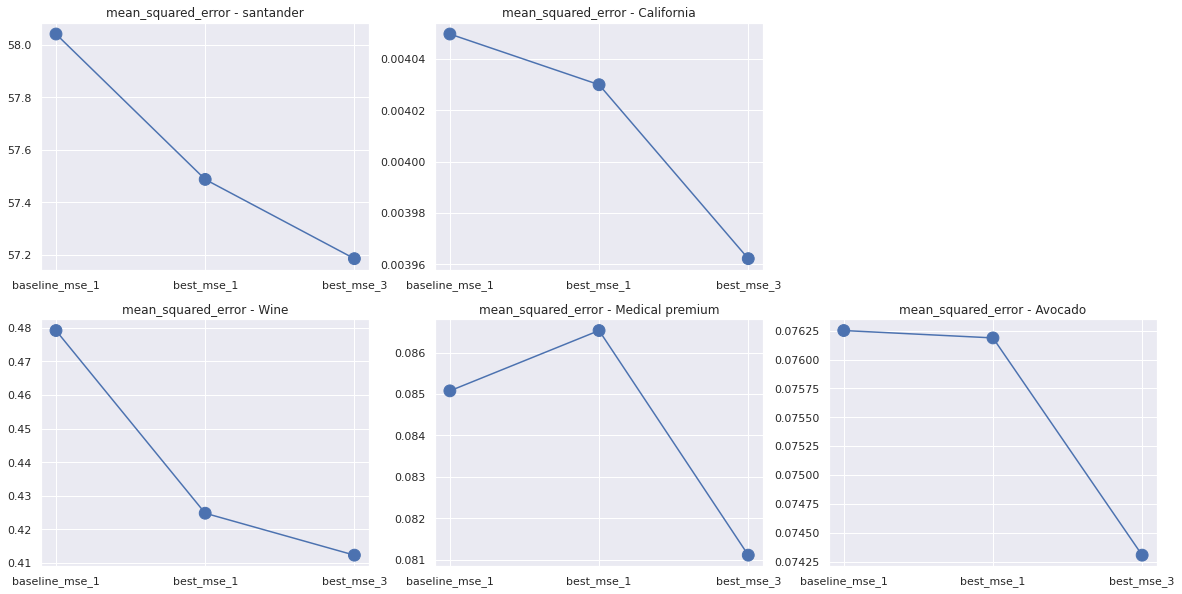

In [34]:
plt.figure(figsize=[20,10])
for row in range(6):
    d = df_reg.loc[row]['dataset']
    if d=="playground":
        continue
    plt.subplot(2,3,row+1)
    plt.scatter(['baseline_mse_1','best_mse_1','best_mse_3'],df_reg[['baseline_mse_1','best_mse_1','best_mse_3']].loc[row],s=[140,140,140])
    plt.plot(['baseline_mse_1','best_mse_1','best_mse_3'],df_reg[['baseline_mse_1','best_mse_1','best_mse_3']].loc[row])

    plt.title(f"mean_squared_error - {d}")
plt.show()

In [35]:
df_class = pd.merge(df_cla3.drop(["total_size","features","baseline_auc_3","run_time_3"],axis=1),df_cla1,on='dataset')
df_class.to_csv("df_class.csv",index=False)
df_class

,dataset,best_auc_3,best_acc_3,baseline_acc_3,best_auc_1,baseline_auc_1,best_acc_1,baseline_acc_1,run_time_1,total_size,features
0,music,0.8986,0.473272,0.463158,0.8967,0.8918,0.469327,0.463158,1239.4510,17996.0,15.0
1,ionosphere,0.9433,0.903134,0.903134,0.9279,0.9190,0.866097,0.903134,21.6875,351.0,35.0
2,santander_customer_satisfaction,0.8241,0.960431,0.960431,0.8214,0.8214,0.960431,0.960431,3105.5964,76020.0,370.0
3,Wids,0.8192,0.812972,0.810997,0.8130,0.8105,0.810360,0.810997,4581.4178,130157.0,162.0
4,fetal_health,0.9653,0.911571,0.908749,0.9583,0.9528,0.914864,0.908749,704.3366,2126.0,22.0


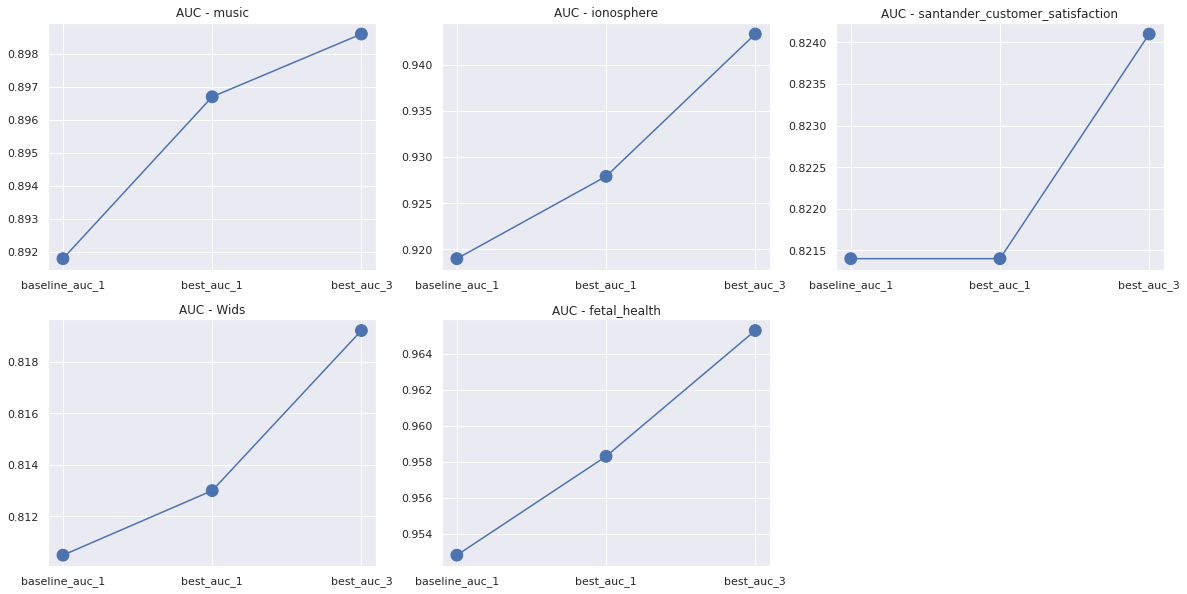

In [36]:
plt.figure(figsize=[20,10])
for row in range(5):
    plt.subplot(2,3,row+1)
    plt.scatter(['baseline_auc_1','best_auc_1','best_auc_3'],df_class[['baseline_auc_1','best_auc_1','best_auc_3']].loc[row],s=[140,140,140])
    plt.plot(['baseline_auc_1','best_auc_1','best_auc_3'],df_class[['baseline_auc_1','best_auc_1','best_auc_3']].loc[row])
    d = df_class.loc[row]['dataset']
    plt.title(f"AUC - {d}")

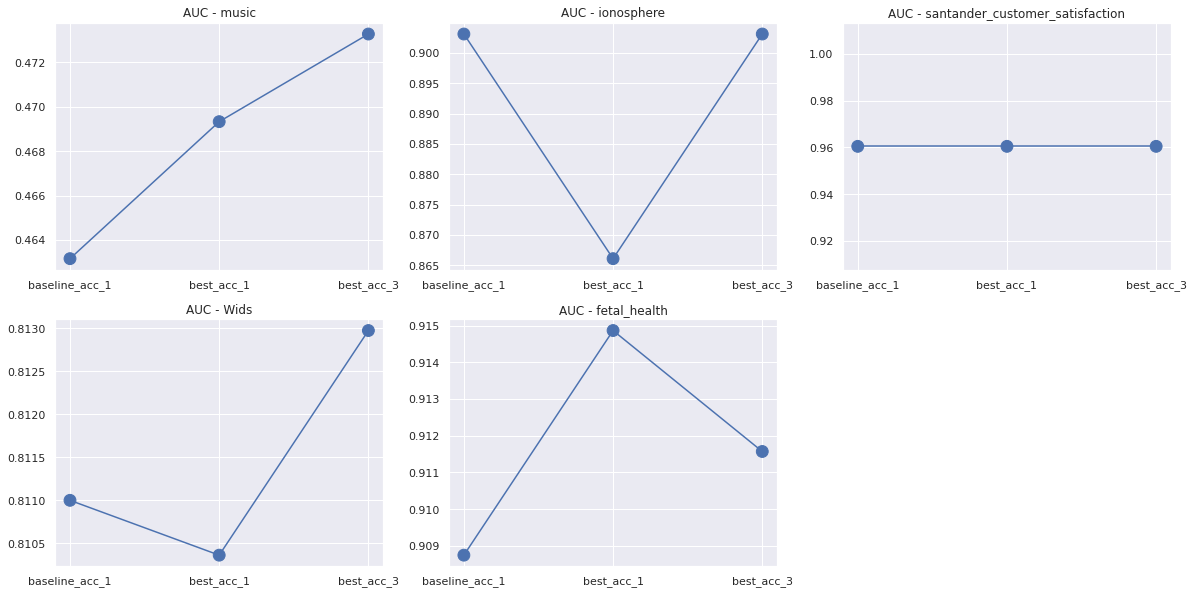

In [39]:
plt.figure(figsize=[20,10])
for row in range(5):
    plt.subplot(2,3,row+1)
    plt.scatter(['baseline_acc_1','best_acc_1','best_acc_3'],df_class[['baseline_acc_1','best_acc_1','best_acc_3']].loc[row],s=[140,140,140])
    plt.plot(['baseline_acc_1','best_acc_1','best_acc_3'],df_class[['baseline_acc_1','best_acc_1','best_acc_3']].loc[row])
    d = df_class.loc[row]['dataset']
    plt.title(f"AUC - {d}")

In [38]:
def get_results_kfold(config_names,q=1):
    reg = []
    cla = []
    for config_name in config_names:
        name = config_name.split(".pkl")[0].split("/")[1]
        with open(config_name, 'rb') as inp:
            config2 = pickle.load(inp)
            h = config2['history']
            for c in range(5):
                fold = h[c]
                try:
                    cla.append([name,c,fold['auc'],fold['acc'],fold['alpha'],fold['iter']])
                except:
                    break
    return pd.DataFrame(cla,columns=['dataset',f'fold',f'auc_{q}',f'acc_{q}',f"alpha_{q}",f'N_{q}'])
    # return df_cla,df_reg

In [29]:
df_1 = get_results_kfold(glob.glob('outputs/*.pkl'),1)
df_3 = get_results_kfold(glob.glob('outputs3/*.pkl'),3)
df = pd.merge(df_1,df_3,on=['dataset','fold'])

In [30]:
df

,dataset,fold,auc_1,acc_1,alpha_1,N_1,auc_3,acc_3,alpha_3,N_3
0,ionosphere,0,0.960684,0.929577,0.118485,41,0.970513,0.915493,0.163188,19
1,ionosphere,1,0.943111,0.871429,0.172630,23,0.931556,0.885714,0.074315,36
2,ionosphere,2,0.889778,0.785714,0.109640,9,0.956444,0.885714,0.332804,13
3,ionosphere,3,0.963556,0.942857,0.083743,85,0.966222,0.942857,0.080822,84
4,ionosphere,4,0.891556,0.800000,0.179071,59,0.943556,0.885714,0.037285,84
5,music,0,0.902137,0.486944,0.086861,91,0.902211,0.481944,0.297264,91
6,music,1,0.894580,0.465963,0.090382,64,0.899067,0.475966,0.266477,92
7,music,2,0.895172,0.471242,0.095431,100,0.894196,0.470131,0.289700,87
8,music,3,0.896971,0.451514,0.114076,96,0.899511,0.460406,0.256648,28
9,music,4,0.895873,0.470964,0.089574,92,0.898672,0.477911,0.273193,51


ValueError: num must be 1 <= num <= 8, not 9

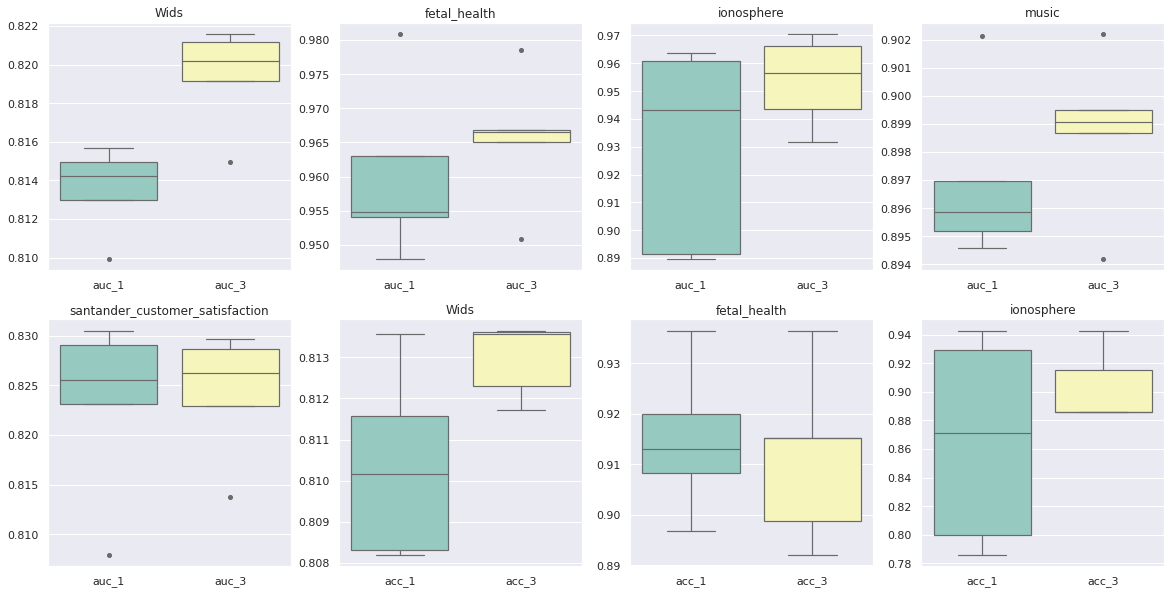

In [370]:
cla = list(df_class.dataset)
plt.figure(figsize=[20,10])
j = 0
for i,mini in df.groupby(["dataset"]):
    if not i in cla:
        continue
    if len(mini)>4:
        plt.subplot(2,4,j+1)
        j+=1
        ax = sns.boxplot(data=mini[['dataset','auc_1','auc_3']], 
                     palette='Set3', 
                     linewidth=1.2, 
                     fliersize=2, 
                     flierprops=dict(marker='o', markersize=4))
        plt.title(i)
for i,mini in df.groupby(["dataset"]):
    if not i in cla:
        continue
    if len(mini)>4:
        plt.subplot(2,4,j+1)
        j+=1
        ax = sns.boxplot(data=mini[['dataset','acc_1','acc_3']], 
                     palette='Set3', 
                     linewidth=1.2, 
                     fliersize=2, 
                     flierprops=dict(marker='o', markersize=4))
        plt.title(i)
plt.show()

In [31]:
# for i,mini in df.groupby(["dataset"]):
#     if len(mini)>4:
#         ax = sns.boxplot(data=mini[['dataset','auc_1','auc_3']], 
#                      palette='Set3', 
#                      linewidth=1.2, 
#                      fliersize=2, 
#                      flierprops=dict(marker='o', markersize=4))
#         plt.show()

In [32]:
# data = glob.glob(f"outputs3/*_0.png")
# sorted(data)
# for i,row in enumerate(data):
#     plt.figure(figsize=[20,20])
#     plt.imshow(plt.imread(row))
#     plt.title(row)
#     plt.show()

In [37]:
!ls outputs/*pkl

outputs/Avocado.pkl	     outputs/playground.pkl
outputs/California.pkl	     outputs/santander_customer_satisfaction.pkl
outputs/fetal_health.pkl     outputs/santander.pkl
outputs/ionosphere.pkl	     outputs/Wids.pkl
outputs/Medical premium.pkl  outputs/Wine.pkl
outputs/music.pkl


In [42]:
with open("outputs/ionosphere.pkl", 'rb') as inp:
    config2 = pickle.load(inp)

In [43]:
suite.run(train_dataset=config2['history'][0]['ds_train'], test_dataset=config2['history'][0]['ds_test'], model=config2['history'][0]['model'])

Full Suite:   0%|          | 0/35 [00:00<?, ? Check/s]